In [1]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kirilldavydov","key":"7484fd1418852c87a3f7d90ba7a06bcc"}'}

In [2]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 69 May 10 00:24 kaggle.json


In [0]:
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

  0% 0.00/7.01k [00:00<?, ?B/s]
100% 7.01k/7.01k [00:00<00:00, 6.86MB/s]
 74% 57.0M/77.3M [00:01<00:00, 30.1MB/s]
100% 77.3M/77.3M [00:01<00:00, 47.2MB/s]
 82% 75.0M/92.0M [00:01<00:00, 43.5MB/s]
100% 92.0M/92.0M [00:01<00:00, 85.6MB/s]
 47% 9.00M/19.3M [00:00<00:00, 27.4MB/s]
100% 19.3M/19.3M [00:00<00:00, 48.8MB/s]
 99% 96.0M/96.6M [00:01<00:00, 64.2MB/s]
100% 96.6M/96.6M [00:01<00:00, 85.8MB/s]


In [0]:
import pandas as pd

In [8]:
!unzip /content/icml_face_data.csv.zip

Archive:  /content/icml_face_data.csv.zip
  inflating: icml_face_data.csv      


In [0]:
df = pd.read_csv('icml_face_data.csv')

In [10]:
df.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [0]:
data = df.values

In [0]:
y = data[:, 0]
pixels = data[:, 2]

In [24]:
import numpy as np # linear algebra
import pandas as pd
from keras.layers import Dense, Convolution2D, UpSampling2D, MaxPooling2D, ZeroPadding2D, Flatten, Dropout, Reshape
from keras.models import Sequential
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
X = np.zeros((pixels.shape[0], 48*48))

for ix in range(X.shape[0]):
    p = pixels[ix].split(' ')
    for iy in range(X.shape[1]):
        X[ix, iy] = int(p[iy])

In [15]:
X

array([[ 70.,  80.,  82., ..., 106., 109.,  82.],
       [151., 150., 147., ..., 193., 183., 184.],
       [231., 212., 156., ...,  88., 110., 152.],
       ...,
       [ 17.,  17.,  16., ..., 154., 133., 113.],
       [ 30.,  28.,  28., ...,  35.,  30.,  28.],
       [ 19.,  13.,  14., ..., 189., 199., 201.]])

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline

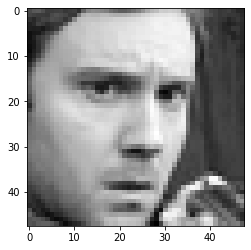

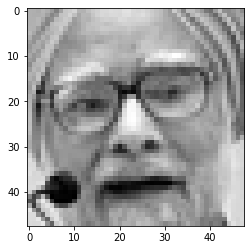

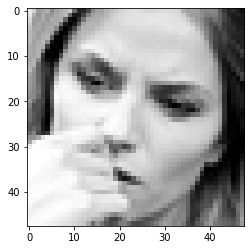

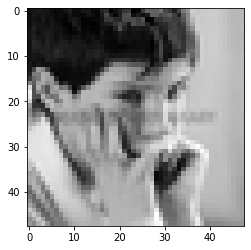

In [17]:
for ix in range(4):
    plt.figure(ix)
    plt.imshow(X[ix].reshape((48, 48)), interpolation='none', cmap='gray')
plt.show()

In [0]:
x = X

In [19]:
X_train = x[0:28710, :]
Y_train = y[0:28710]
print (X_train.shape, Y_train.shape)
X_crossval = x[28710:32300, :]
Y_crossval = y[28710:32300]
print (X_crossval.shape, Y_crossval.shape)

(28710, 2304) (28710,)
(3590, 2304) (3590,)


In [0]:
X_train = X_train.reshape((X_train.shape[0], 48 , 48, 1 ))
X_crossval = X_crossval.reshape((X_crossval.shape[0], 48 ,48, 1))

In [50]:

X_crossval.shape

(3590, 48, 48, 1)

In [40]:
print (y.shape)
y_ = np_utils.to_categorical(y, 7)
print (y_.shape)

(35887,)
(35887, 7)


In [41]:
Y_train = y_[:28710]
Y_crossval = y_[28710:32300]
print (X_crossval.shape, Y_crossval.shape)

(3590, 48, 48, 1) (3590, 7)


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.0,  
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=False, 
        vertical_flip=False)  

datagen.fit(X_train)

In [28]:
from keras.callbacks import ReduceLROnPlateau
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [0]:
from keras.layers import Dense , Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , Adam
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.common.set_image_dim_ordering('th')

In [0]:
def swish_activation(x):
    return (K.sigmoid(x) * x)

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(48,48,1)))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation=swish_activation))
model.add(Dropout(0.4))
model.add(Dense(7 , activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam' ,
              metrics=['accuracy'])

In [35]:
print(model.summary())


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 96)       

In [0]:
batch_size = 128
epochs = 14

model.compile(loss='binary_crossentropy', optimizer='adam' , metrics=['accuracy'])
steps_per_epoch = len(X) // batch_size
validation_steps = len((X_crossval, Y_crossval)) // batch_size

In [43]:
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                    steps_per_epoch=X.shape[0] // batch_size,
                    callbacks=[lr_reduce],
                    validation_data=(X_crossval, Y_crossval),
                    epochs = epochs, verbose = 2)

Epoch 1/14
 - 21s - loss: 0.4050 - accuracy: 0.8543 - val_loss: 0.3742 - val_accuracy: 0.8571
Epoch 2/14


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 14s - loss: 0.3574 - accuracy: 0.8669 - val_loss: 0.3243 - val_accuracy: 0.8753
Epoch 3/14
 - 14s - loss: 0.3238 - accuracy: 0.8766 - val_loss: 0.2991 - val_accuracy: 0.8833
Epoch 4/14
 - 14s - loss: 0.3017 - accuracy: 0.8822 - val_loss: 0.2856 - val_accuracy: 0.8876
Epoch 5/14
 - 14s - loss: 0.2885 - accuracy: 0.8856 - val_loss: 0.2700 - val_accuracy: 0.8911
Epoch 6/14
 - 13s - loss: 0.2767 - accuracy: 0.8895 - val_loss: 0.2705 - val_accuracy: 0.8904
Epoch 7/14
 - 14s - loss: 0.2693 - accuracy: 0.8920 - val_loss: 0.2607 - val_accuracy: 0.8945
Epoch 8/14
 - 14s - loss: 0.2625 - accuracy: 0.8945 - val_loss: 0.2579 - val_accuracy: 0.8960
Epoch 9/14
 - 14s - loss: 0.2550 - accuracy: 0.8975 - val_loss: 0.2516 - val_accuracy: 0.8986
Epoch 10/14
 - 14s - loss: 0.2503 - accuracy: 0.8994 - val_loss: 0.2548 - val_accuracy: 0.8992
Epoch 11/14
 - 14s - loss: 0.2462 - accuracy: 0.9011 - val_loss: 0.2523 - val_accuracy: 0.8980
Epoch 12/14
 - 13s - loss: 0.2424 - accuracy: 0.9025 - val_loss: 0.25

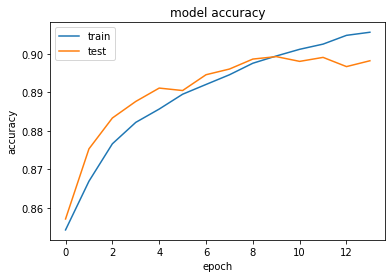

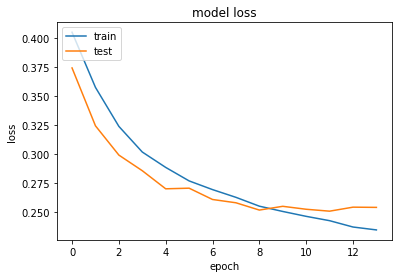

In [46]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
prediction = model.predict(X_crossval)

In [72]:
np.argmax(prediction[1])

0

In [73]:
np.argmax(Y_crossval[1])

4

In [74]:
Y_crossval[5]

array([0., 0., 1., 0., 0., 0., 0.], dtype=float32)

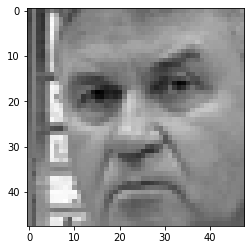

In [75]:
plt.figure(ix)
plt.imshow(X[28711].reshape((48, 48)), interpolation='none', cmap='gray')